In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [7]:
import os
import glob
import numpy as np
import scipy.io as sio
import cv2
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BASE_PATH = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/lizard"

# Define the paths based on your tree output
IMG_DIR_1 = os.path.join(BASE_PATH, "lizard_images1", "Lizard_Images1")
IMG_DIR_2 = os.path.join(BASE_PATH, "lizard_images2", "Lizard_Images2")
LABEL_DIR = os.path.join(BASE_PATH, "lizard_labels", "Lizard_Labels", "Labels")

def inspect_pair(image_name):
    print(f"\n=== Investigating Pair for: {image_name} ===")
    
    # 1. Find Image
    img_path_1 = os.path.join(IMG_DIR_1, image_name)
    img_path_2 = os.path.join(IMG_DIR_2, image_name)
    
    if os.path.exists(img_path_1):
        img_path = img_path_1
        print(f"  [Image Found in]: lizard_images1")
    elif os.path.exists(img_path_2):
        img_path = img_path_2
        print(f"  [Image Found in]: lizard_images2")
    else:
        print(f"  [Error]: Image {image_name} not found in either image folder.")
        return

    # 2. Find Label
    # Labels are .mat files, so replace .png with .mat
    label_name = image_name.replace(".png", ".mat")
    label_path = os.path.join(LABEL_DIR, label_name)
    
    if not os.path.exists(label_path):
        print(f"  [Error]: Corresponding label {label_name} not found.")
        return

    # 3. Load and Analyze Image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for correctness
    print(f"  [Image Shape]: {img.shape} (H, W, C)")
    print(f"  [Image Range]: {img.min()} - {img.max()} (Type: {img.dtype})")

    # 4. Load and Analyze Label (.mat)
    try:
        mat = sio.loadmat(label_path)
        print(f"  [Mat File Keys]: {[k for k in mat.keys() if not k.startswith('__')]}")
        
        # Lizard dataset typically has 'inst_map' (instances) or 'class'
        # We will iterate through keys to find the mask
        for key in mat:
            if key.startswith('__'): continue
            
            data = mat[key]
            if isinstance(data, np.ndarray):
                print(f"    -> Key '{key}': Shape {data.shape}, Dtype {data.dtype}")
                
                # If it looks like a mask (2D array)
                if len(data.shape) == 2:
                    unique_vals = np.unique(data)
                    print(f"       [Unique Values/Classes]: {unique_vals}")
                    if len(unique_vals) > 50:
                        print("       (Likely an Instance Map with many individual cells)")
                    else:
                        print("       (Likely a Class Map)")
    except Exception as e:
        print(f"  [Error reading .mat]: {e}")

def main():
    # Gather all images
    imgs1 = glob.glob(os.path.join(IMG_DIR_1, "*.png"))
    imgs2 = glob.glob(os.path.join(IMG_DIR_2, "*.png"))
    all_images = imgs1 + imgs2
    
    print(f"Found {len(imgs1)} images in folder 1")
    print(f"Found {len(imgs2)} images in folder 2")
    print(f"Total Images: {len(all_images)}")
    
    labels = glob.glob(os.path.join(LABEL_DIR, "*.mat"))
    print(f"Total Labels: {len(labels)}")
    
    # Check consistency
    if len(all_images) != len(labels):
        print("WARNING: Mismatch between number of images and labels!")
    
    # Pick 3 random samples to inspect
    if len(all_images) > 0:
        samples = [os.path.basename(x) for x in np.random.choice(all_images, 3, replace=False)]
        for s in samples:
            inspect_pair(s)

if __name__ == "__main__":
    main()

Found 80 images in folder 1
Found 158 images in folder 2
Total Images: 238
Total Labels: 238

=== Investigating Pair for: dpath_41.png ===
  [Image Found in]: lizard_images2
  [Image Shape]: (1099, 1302, 3) (H, W, C)
  [Image Range]: 6 - 255 (Type: uint8)
  [Mat File Keys]: ['inst_map', 'id', 'class', 'bbox', 'centroid']
    -> Key 'inst_map': Shape (1099, 1302), Dtype int32
       [Unique Values/Classes]: [   0    1    2 ... 2179 2180 2181]
       (Likely an Instance Map with many individual cells)
    -> Key 'id': Shape (2181, 1), Dtype int32
       [Unique Values/Classes]: [   1    2    3 ... 2179 2180 2181]
       (Likely an Instance Map with many individual cells)
    -> Key 'class': Shape (2181, 1), Dtype uint8
       [Unique Values/Classes]: [1 2 3 4 5 6]
       (Likely a Class Map)
    -> Key 'bbox': Shape (2181, 4), Dtype int32
       [Unique Values/Classes]: [   0    1    2 ... 1300 1301 1302]
       (Likely an Instance Map with many individual cells)
    -> Key 'centroid': S

[Init] Found 238 images.

Loaded: consep_1.png
Image Shape: (500, 500, 3)
Mask Shape: (500, 500)
Unique Classes in Mask: [0 2 3 6]


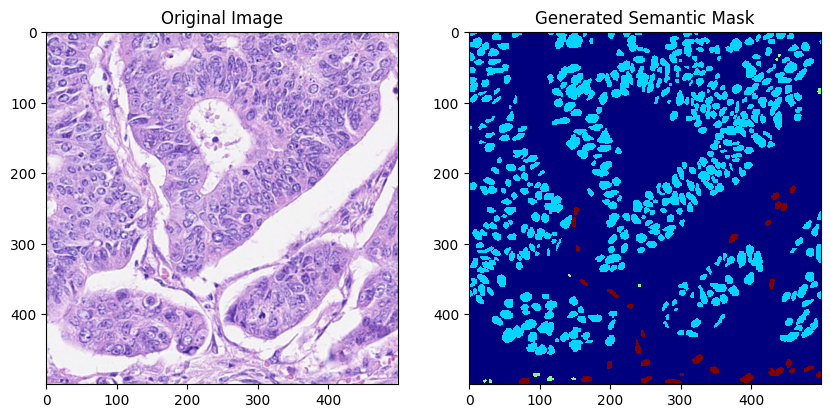

In [8]:
import os
import glob
import numpy as np
import scipy.io as sio
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class LizardDataset(Dataset):
    def __init__(self, base_path, transform=None):
        """
        Args:
            base_path (str): Root directory (/rsrch9/.../lizard)
            transform (callable, optional): Albumentations or Torchvision transforms.
        """
        self.base_path = base_path
        self.transform = transform
        
        # 1. Define Paths
        img_dir1 = os.path.join(base_path, "lizard_images1", "Lizard_Images1")
        img_dir2 = os.path.join(base_path, "lizard_images2", "Lizard_Images2")
        self.label_dir = os.path.join(base_path, "lizard_labels", "Lizard_Labels", "Labels")
        
        # 2. Gather all images
        self.images = glob.glob(os.path.join(img_dir1, "*.png")) + \
                      glob.glob(os.path.join(img_dir2, "*.png"))
        
        print(f"[Init] Found {len(self.images)} images.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # --- A. Load Image ---
        img_path = self.images[idx]
        file_name = os.path.basename(img_path)
        
        # Load and convert to RGB
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # --- B. Load Label (.mat) ---
        label_name = file_name.replace(".png", ".mat")
        label_path = os.path.join(self.label_dir, label_name)
        
        mat = sio.loadmat(label_path)
        inst_map = mat['inst_map']  # Unique ID for every cell (0, 1, 2... N)
        class_ids = mat['class']    # Class type for every ID (e.g., 1=Neutrophil)
        
        # --- C. Fast Conversion: Instance Map -> Semantic Map ---
        # We use a Lookup Table (LUT) to map every Unique ID to its Class ID instantly.
        
        # 1. Create a lookup array. Size = max instance ID + 1.
        #    Initialize with 0 (background).
        max_id = np.max(inst_map)
        lut = np.zeros(max_id + 1, dtype=np.uint8)
        
        # 2. Populate the table. 
        #    'class_ids' from .mat corresponds to instance 1, 2, 3...
        #    We flatten class_ids to make it a 1D vector.
        #    Note: We slice [:max_id] just in case the class list is longer than actual pixels found.
        lut[1:len(class_ids)+1] = class_ids.flatten()
        
        # 3. Apply lookup. This replaces every pixel value 'i' with 'lut[i]'
        semantic_mask = lut[inst_map] 
        
        # --- D. Returns ---
        if self.transform:
            # Assumes Albumentations format: transform(image=x, mask=y)
            augmented = self.transform(image=image, mask=semantic_mask)
            image = augmented['image']
            semantic_mask = augmented['mask']
            
        return image, semantic_mask, file_name

# --- TEST CODE TO VERIFY IT WORKS ---
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    BASE_PATH = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/lizard"
    
    # Initialize Dataset
    ds = LizardDataset(BASE_PATH)
    
    # Fetch one sample
    img, mask, fname = ds[0]
    
    print(f"\nLoaded: {fname}")
    print(f"Image Shape: {img.shape}")
    print(f"Mask Shape: {mask.shape}")
    print(f"Unique Classes in Mask: {np.unique(mask)}") 
    # ^ Expect [0, 1, 2, ...] instead of [0, 321, 599...]

    # Visualize
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='jet', interpolation='nearest')
    plt.title("Generated Semantic Mask")
    plt.show()

In [9]:
import os
import glob
import cv2
import pandas as pd
from collections import Counter

# --- CONFIGURATION ---
BASE_PATH = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/lizard"
IMG_DIRS = [
    os.path.join(BASE_PATH, "lizard_images1", "Lizard_Images1"),
    os.path.join(BASE_PATH, "lizard_images2", "Lizard_Images2")
]

def check_sizes():
    print("--- Scanning Image Sizes ---")
    
    # 1. Gather all file paths
    all_img_paths = []
    for d in IMG_DIRS:
        all_img_paths.extend(glob.glob(os.path.join(d, "*.png")))
    
    print(f"Total Images Found: {len(all_img_paths)}")
    
    # 2. Read dimensions for every image
    sizes = []
    for p in all_img_paths:
        # We read only the header to speed it up (no need to decode pixel data)
        # However, cv2.imread loads data. For speed on huge datasets we'd use PIL, 
        # but cv2 is fine for ~200 images.
        img = cv2.imread(p)
        if img is not None:
            h, w = img.shape[:2]
            sizes.append((h, w))
    
    # 3. Count frequencies
    size_counts = Counter(sizes)
    
    # 4. Convert to DataFrame for nice display
    df = pd.DataFrame(size_counts.items(), columns=['Size (H, W)', 'Count'])
    df = df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    
    # 5. Print Statistics
    print("\n=== Size Distribution Table ===")
    print(df.to_string())
    
    # Summary Analysis
    unique_sizes = len(size_counts)
    print(f"\n[Summary]:")
    print(f"  - There are {unique_sizes} different image sizes.")
    if unique_sizes == 1:
        print("  - PERFECT: All images are the same size.")
    else:
        print("  - WARNING: Images vary in size. You will need resizing or cropping for training.")
        min_h = min(s[0] for s in sizes)
        min_w = min(s[1] for s in sizes)
        print(f"  - Smallest dimensions found: H={min_h}, W={min_w}")

if __name__ == "__main__":
    check_sizes()

--- Scanning Image Sizes ---
Total Images Found: 238

=== Size Distribution Table ===
     Size (H, W)  Count
0     (522, 775)     56
1     (500, 500)     37
2   (1516, 1511)     22
3   (1516, 1509)     12
4   (1516, 1512)     10
5   (1516, 1508)      7
6   (1516, 1500)      6
7     (512, 512)      6
8   (1516, 1514)      3
9     (453, 589)      3
10  (1516, 1319)      2
11  (1516, 1505)      2
12   (805, 1247)      1
13   (1142, 854)      1
14   (878, 1641)      1
15  (2117, 1047)      1
16   (794, 1047)      1
17    (967, 996)      1
18    (760, 738)      1
19   (854, 1172)      1
20  (1005, 1268)      1
21   (981, 1311)      1
22   (867, 1028)      1
23   (911, 1035)      1
24  (1057, 1137)      1
25  (2095, 1842)      1
26    (699, 970)      1
27   (874, 1017)      1
28   (932, 1073)      1
29    (433, 574)      1
30    (442, 581)      1
31  (1050, 1413)      1
32   (860, 1103)      1
33   (972, 1236)      1
34    (337, 512)      1
35  (1359, 1607)      1
36  (1061, 1271)      1
37

## patches

In [12]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import scipy.io as sio
import cv2
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
base_lizard = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/lizard")
img_dir1 = base_lizard / "lizard_images1/Lizard_Images1"
img_dir2 = base_lizard / "lizard_images2/Lizard_Images2"
label_dir = base_lizard / "lizard_labels/Lizard_Labels/Labels"

# Output Path
output_base_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_stacked")

patch_size = 512
num_workers = 64  # Stacking uses more RAM, so slightly fewer workers is safer

# ---------------------------------------------------------------------
# 2. Helper Functions
# ---------------------------------------------------------------------
def get_smart_coords(length, crop_size):
    """Generates start coordinates with overlap logic."""
    if length <= crop_size:
        return [0]
    coords = list(range(0, length - crop_size, crop_size))
    coords.append(length - crop_size) # Add final chunk
    return sorted(list(set(coords)))

def process_and_stack_slide(args):
    """
    Reads ONE Slide, crops it completely, stacks crops, and saves ONE Zarr group.
    Result shape: (N_Crops, 512, 512, 3) -> Identical to Xenium structure.
    """
    img_path, label_path, file_name, out_dir = args
    
    try:
        # --- A. Load & Pad ---
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mat = sio.loadmat(label_path)
        inst_map = mat['inst_map'].astype(np.int32)
        
        h, w = img.shape[:2]
        
        # Pad if smaller than 512
        pad_h = max(0, patch_size - h)
        pad_w = max(0, patch_size - w)
        if pad_h > 0 or pad_w > 0:
            img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), constant_values=0)
            inst_map = np.pad(inst_map, ((0, pad_h), (0, pad_w)), constant_values=0)
            h, w = img.shape[:2]

        # --- B. Generate All Crops ---
        y_points = get_smart_coords(h, patch_size)
        x_points = get_smart_coords(w, patch_size)
        
        img_stack = []
        nuc_stack = []
        metadata_list = []
        
        for y in y_points:
            for x in x_points:
                crop_img = img[y : y+patch_size, x : x+patch_size]
                crop_nuc = inst_map[y : y+patch_size, x : x+patch_size]
                
                # Sanity Check
                if crop_img.shape == (patch_size, patch_size, 3):
                    img_stack.append(crop_img)
                    nuc_stack.append(crop_nuc)
                    metadata_list.append({
                        'original_file': file_name,
                        'x': x, 'y': y
                    })

        # --- C. Stack to Numpy ---
        # Shape becomes (N, 512, 512, 3)
        final_imgs = np.stack(img_stack, axis=0)
        final_nucs = np.stack(nuc_stack, axis=0)
        num_patches = final_imgs.shape[0]

        # --- D. Save as Single Zarr Group ---
        slide_out_path = out_dir / file_name
        os.makedirs(slide_out_path, exist_ok=True)
        
        # Images: (N, 512, 512, 3) uint8
        z_img = zarr.open(
            slide_out_path / 'images.zarr', mode='w',
            shape=final_imgs.shape,
            chunks=(1, 512, 512, 3), # Chunk size = 1 image
            dtype='uint8',
            compressor=zarr.Blosc(cname='zstd', clevel=3)
        )
        z_img[:] = final_imgs
        
        # Masks: (N, 512, 512) int32
        z_nuc = zarr.open(
            slide_out_path / 'nuclei_masks.zarr', mode='w',
            shape=final_nucs.shape,
            chunks=(1, 512, 512),
            dtype='int32',
            compressor=zarr.Blosc(cname='zstd', clevel=3)
        )
        z_nuc[:] = final_nucs
        
        pd.DataFrame(metadata_list).to_csv(slide_out_path / 'metadata.csv', index=False)
        
        return num_patches

    except Exception as e:
        print(f"Error {file_name}: {e}")
        return 0

# ---------------------------------------------------------------------
# 3. Main Loop
# ---------------------------------------------------------------------
if __name__ == "__main__":
    print(f"🦎 LIZARD STACKED CONVERSION (Matching Xenium Structure)")
    
    # Gather Files
    all_images = sorted(list(glob.glob(str(img_dir1 / "*.png"))) + \
                        list(glob.glob(str(img_dir2 / "*.png"))))
    
    output_base_path.mkdir(parents=True, exist_ok=True)
    
    tasks = []
    for img_p in all_images:
        path_obj = Path(img_p)
        fname = path_obj.stem
        lbl_path = label_dir / f"{fname}.mat"
        if lbl_path.exists():
            tasks.append((path_obj, lbl_path, fname, output_base_path))
            
    print(f"Processing {len(tasks)} slides...")
    
    total_patches = 0
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        results = list(tqdm(executor.map(process_and_stack_slide, tasks), total=len(tasks)))
        
    print(f"Done! Created {sum(results)} patches stacked across {len(tasks)} files.")
    print(f"Output: {output_base_path}")

🦎 LIZARD STACKED CONVERSION (Matching Xenium Structure)
Processing 238 slides...


100%|██████████| 238/238 [00:07<00:00, 30.95it/s]


Done! Created 1395 patches stacked across 238 files.
Output: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_stacked


🔎 Inspecting Lizard Path: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_data/consep_13
🔎 Comparing against Xenium Sample: lymph_node

🧬 STRUCTURAL COMPARISON
Lizard: (1, 512, 512, 3) (Stacked) | Max ID: 646
Xenium: (53, 512, 512, 3) (Stacked) | Max ID: 684433

👁️ VISUAL INTEGRITY CHECK (Randomized Colors)


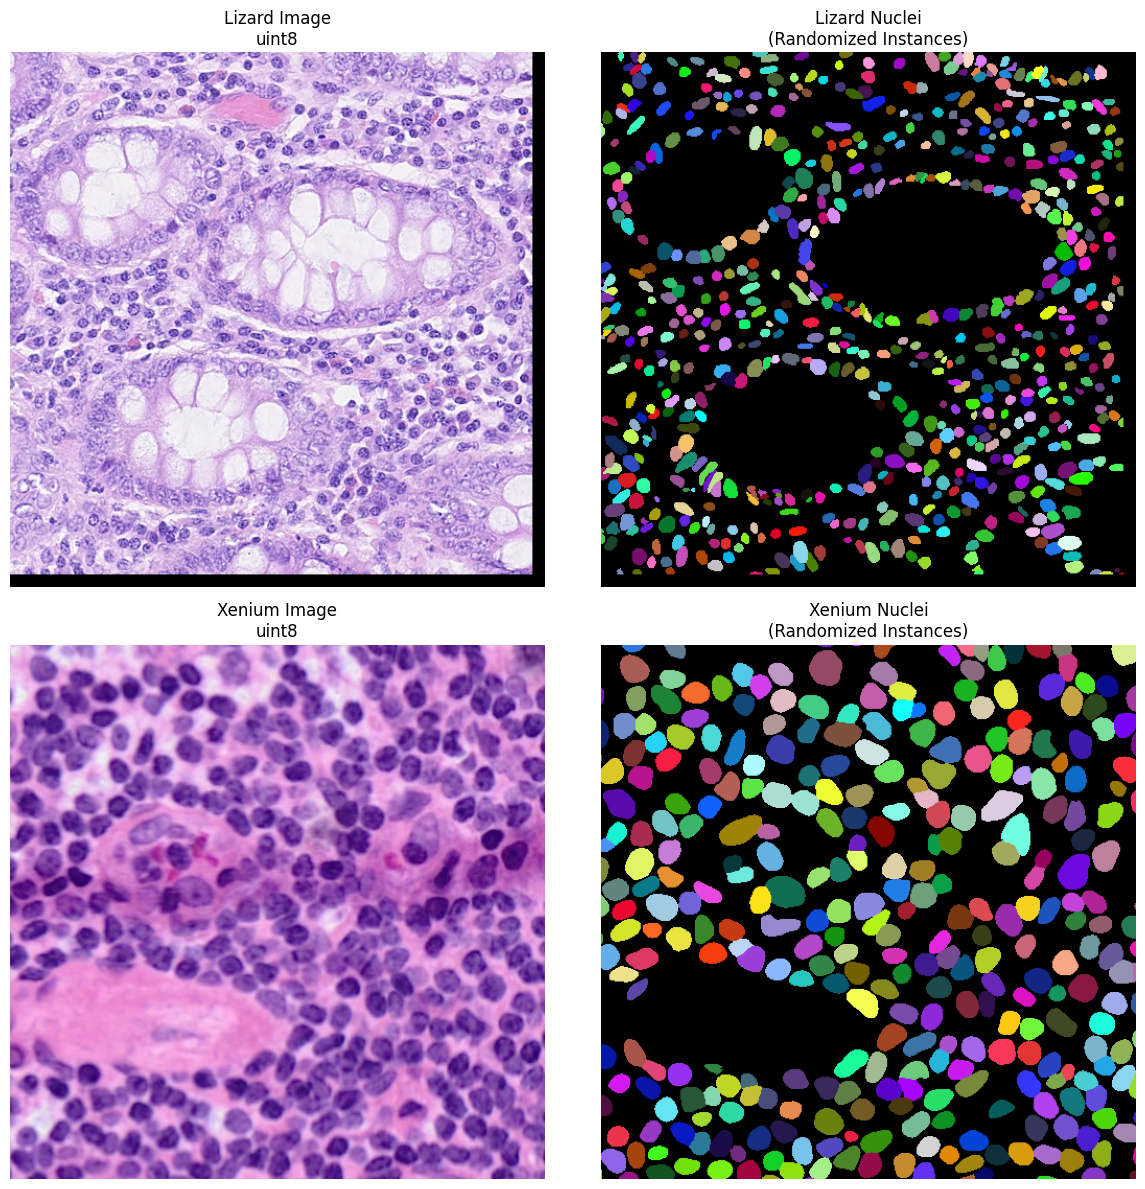

In [23]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
# UPDATED PATH: Pointing to the new "stacked" folder
lizard_base_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_data"
xenium_base_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/Xenium/zarr_data"

# Find a random Lizard sample
if os.path.exists(lizard_base_path):
    lizard_samples = sorted([d for d in os.listdir(lizard_base_path) 
                             if os.path.isdir(os.path.join(lizard_base_path, d))])
    lizard_sample_path = os.path.join(lizard_base_path, lizard_samples[4]) if lizard_samples else None
else:
    lizard_sample_path = None

# Find a random Xenium sample
if os.path.exists(xenium_base_path):
    xenium_samples = sorted([d for d in os.listdir(xenium_base_path) 
                             if os.path.isdir(os.path.join(xenium_base_path, d))])
    xenium_sample_path = os.path.join(xenium_base_path, xenium_samples[4]) if xenium_samples else None
else:
    xenium_sample_path = None

print(f"🔎 Inspecting Lizard Path: {lizard_sample_path}")
if xenium_sample_path: print(f"🔎 Comparing against Xenium Sample: {os.path.basename(xenium_sample_path)}")

# ---------------------------------------------------------------------
# 2. Metadata Extraction
# ---------------------------------------------------------------------
def get_he_info(path, label="Dataset"):
    info = {'exists': False, 'label': label}
    if not path: return info

    # Check potential internal paths
    paths_to_check = [os.path.join(path, 'he'), path, os.path.join(path, 'mif')]
    target_path = next((p for p in paths_to_check if os.path.exists(os.path.join(p, 'images.zarr'))), None)

    if not target_path:
        info['error'] = "images.zarr not found"
        return info

    try:
        img = zarr.open(os.path.join(target_path, 'images.zarr'), mode='r')
        nuc_path = os.path.join(target_path, 'nuclei_masks.zarr')
        nuc = zarr.open(nuc_path, mode='r') if os.path.exists(nuc_path) else None

        info.update({
            'exists': True,
            'img_shape': img.shape, 'img_dtype': img.dtype,
            'sample_img': img[0], 'has_mask': nuc is not None
        })
        
        if nuc is not None:
            info.update({'mask_dtype': nuc.dtype, 'sample_nuc': nuc[0], 'nuc_max_id': np.max(nuc[0])})
        else:
            info.update({'mask_dtype': "N/A", 'sample_nuc': np.zeros(img.shape[1:3]), 'nuc_max_id': 0})

    except Exception as e:
        info['error'] = str(e)
    return info

# Run Analysis
lz_info = get_he_info(lizard_sample_path, label="Lizard")
xen_info = get_he_info(xenium_sample_path, label="Xenium") if xenium_sample_path else None

# ---------------------------------------------------------------------
# 3. Visualization Helper (Random Colors)
# ---------------------------------------------------------------------
def colorize_instance_map(instance_map):
    """
    Converts a 2D instance map (int) into a 3D RGB image (float) 
    where every ID gets a random color. Background (0) is black.
    """
    max_id = int(instance_map.max())
    if max_id == 0:
        return np.zeros((*instance_map.shape, 3))
    
    # 1. Generate random colors for every possible ID (plus one for 0)
    # Shape: (Max_ID + 1, 3)
    colors = np.random.rand(max_id + 1, 3)
    
    # 2. Force Background (ID 0) to Black
    colors[0] = [0, 0, 0]
    
    # 3. Apply lookup (Fancy Indexing)
    # This replaces every integer ID with its corresponding RGB vector
    color_image = colors[instance_map]
    
    return color_image

# ---------------------------------------------------------------------
# 4. Report & Plots
# ---------------------------------------------------------------------
print("\n" + "="*80 + "\n🧬 STRUCTURAL COMPARISON\n" + "="*80)

if lz_info['exists']:
    print(f"Lizard: {lz_info['img_shape']} (Stacked) | Max ID: {lz_info['nuc_max_id']}")
if xen_info and xen_info['exists']:
    print(f"Xenium: {xen_info['img_shape']} (Stacked) | Max ID: {xen_info['nuc_max_id']}")

print("\n" + "="*80 + "\n👁️ VISUAL INTEGRITY CHECK (Randomized Colors)\n" + "="*80)

if lz_info['exists']:
    rows = 2 if (xen_info and xen_info['exists']) else 1
    fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows))
    if rows == 1: axes = np.expand_dims(axes, axis=0)

    # --- Lizard ---
    # Image
    axes[0, 0].imshow(lz_info['sample_img'])
    axes[0, 0].set_title(f"Lizard Image\n{lz_info['img_dtype']}")
    axes[0, 0].axis('off')
    
    # Random Color Mask
    lz_colored = colorize_instance_map(lz_info['sample_nuc'])
    axes[0, 1].imshow(lz_colored)
    axes[0, 1].set_title("Lizard Nuclei\n(Randomized Instances)")
    axes[0, 1].axis('off')

    # --- Xenium ---
    if rows > 1:
        # Image
        xen_img = xen_info['sample_img']
        if xen_img.ndim == 3 and xen_img.shape[2] == 3:
            axes[1, 0].imshow(xen_img)
        else:
            axes[1, 0].imshow(xen_img, cmap='gray')
        axes[1, 0].set_title(f"Xenium Image\n{xen_info['img_dtype']}")
        axes[1, 0].axis('off')

        # Random Color Mask
        xen_colored = colorize_instance_map(xen_info['sample_nuc'])
        axes[1, 1].imshow(xen_colored)
        axes[1, 1].set_title("Xenium Nuclei\n(Randomized Instances)")
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

## Split

In [24]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import shutil
from pathlib import Path
from tqdm import tqdm
import random

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
# Input: The folder containing the 238 separate slide folders
input_base = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_data")

# Output: Where the 3 merged splits will go
output_base = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_splits")

# Ratios
TRAIN_RATIO = 0.85
VAL_RATIO = 0.05
# Test gets the remainder (approx 0.10)

SEED = 42

# ---------------------------------------------------------------------
# 2. Helper Functions
# ---------------------------------------------------------------------
def merge_and_save(split_name, folder_list, dest_root):
    """
    Reads multiple Zarr folders and concatenates them into one big Zarr.
    """
    if not folder_list:
        print(f"⚠️  Skipping {split_name} (No folders found)")
        return

    dest_path = dest_root / split_name
    if dest_path.exists():
        shutil.rmtree(dest_path)
    dest_path.mkdir(parents=True, exist_ok=True)

    print(f"\n📦 Merging {len(folder_list)} slides into '{split_name}'...")

    all_imgs = []
    all_masks = []
    all_meta = []

    # --- Load all data into memory (Safe for ~1GB total) ---
    for folder in tqdm(folder_list, desc=f"Loading {split_name}"):
        try:
            # Open Zarrs
            z_img = zarr.open(folder / "images.zarr", mode='r')
            z_msk = zarr.open(folder / "nuclei_masks.zarr", mode='r')
            
            # Read to Numpy
            img_arr = z_img[:]
            msk_arr = z_msk[:]
            
            # Read Metadata
            meta_path = folder / "metadata.csv"
            if meta_path.exists():
                df = pd.read_csv(meta_path)
                all_meta.append(df)
            
            all_imgs.append(img_arr)
            all_masks.append(msk_arr)
            
        except Exception as e:
            print(f"Failed to load {folder.name}: {e}")

    # --- Concatenate ---
    final_imgs = np.concatenate(all_imgs, axis=0)
    final_masks = np.concatenate(all_masks, axis=0)
    
    if all_meta:
        final_meta = pd.concat(all_meta, ignore_index=True)
        # Add a split column for reference
        final_meta['split'] = split_name
        final_meta.to_csv(dest_path / "metadata.csv", index=False)

    print(f"   -> Saving {final_imgs.shape[0]} patches to disk...")

    # --- Save merged Zarr ---
    # Images (uint8)
    z_out_img = zarr.open(
        dest_path / 'images.zarr', 
        mode='w', 
        shape=final_imgs.shape, 
        chunks=(1, 512, 512, 3), 
        dtype='uint8',
        compressor=zarr.Blosc(cname='zstd', clevel=3)
    )
    z_out_img[:] = final_imgs

    # Masks (int32)
    z_out_nuc = zarr.open(
        dest_path / 'nuclei_masks.zarr', 
        mode='w', 
        shape=final_masks.shape, 
        chunks=(1, 512, 512), 
        dtype='int32',
        compressor=zarr.Blosc(cname='zstd', clevel=3)
    )
    z_out_nuc[:] = final_masks
    
    print(f"   ✅ Saved {split_name}: {final_imgs.shape}")

# ---------------------------------------------------------------------
# 3. Main Logic
# ---------------------------------------------------------------------
if __name__ == "__main__":
    random.seed(SEED)
    
    # 1. Get all slide directories
    slides = sorted([p for p in input_base.iterdir() if p.is_dir()])
    total_slides = len(slides)
    print(f"Found {total_slides} total slides.")
    
    # 2. Shuffle
    random.shuffle(slides)
    
    # 3. Split Indices
    n_train = int(total_slides * TRAIN_RATIO)
    n_val = int(total_slides * VAL_RATIO)
    # n_test is the rest
    
    train_slides = slides[:n_train]
    val_slides = slides[n_train : n_train + n_val]
    test_slides = slides[n_train + n_val:]
    
    print(f"Split Breakdown:")
    print(f"  Train: {len(train_slides)} slides")
    print(f"  Val:   {len(val_slides)} slides")
    print(f"  Test:  {len(test_slides)} slides")
    
    # 4. Execute Merge
    merge_and_save("train", train_slides, output_base)
    merge_and_save("val", val_slides, output_base)
    merge_and_save("test", test_slides, output_base)
    
    print(f"\n{'='*60}")
    print(f"🎉 DONE. New organized dataset at: {output_base}")
    print(f"{'='*60}")

Found 238 total slides.
Split Breakdown:
  Train: 202 slides
  Val:   11 slides
  Test:  25 slides

📦 Merging 202 slides into 'train'...


Loading train: 100%|██████████| 202/202 [01:09<00:00,  2.89it/s]


   -> Saving 1184 patches to disk...
   ✅ Saved train: (1184, 512, 512, 3)

📦 Merging 11 slides into 'val'...


Loading val: 100%|██████████| 11/11 [00:01<00:00,  6.93it/s]


   -> Saving 60 patches to disk...
   ✅ Saved val: (60, 512, 512, 3)

📦 Merging 25 slides into 'test'...


Loading test: 100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


   -> Saving 151 patches to disk...
   ✅ Saved test: (151, 512, 512, 3)

🎉 DONE. New organized dataset at: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_splits


🚀 VERIFYING DATASET AT: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_splits

📂 Checking Split: TRAIN
   ✅ Images: (1184, 512, 512, 3) | uint8
   ✅ Masks:  (1184, 512, 512) | int32
   👁️ Visualizing indices: [193, 389]


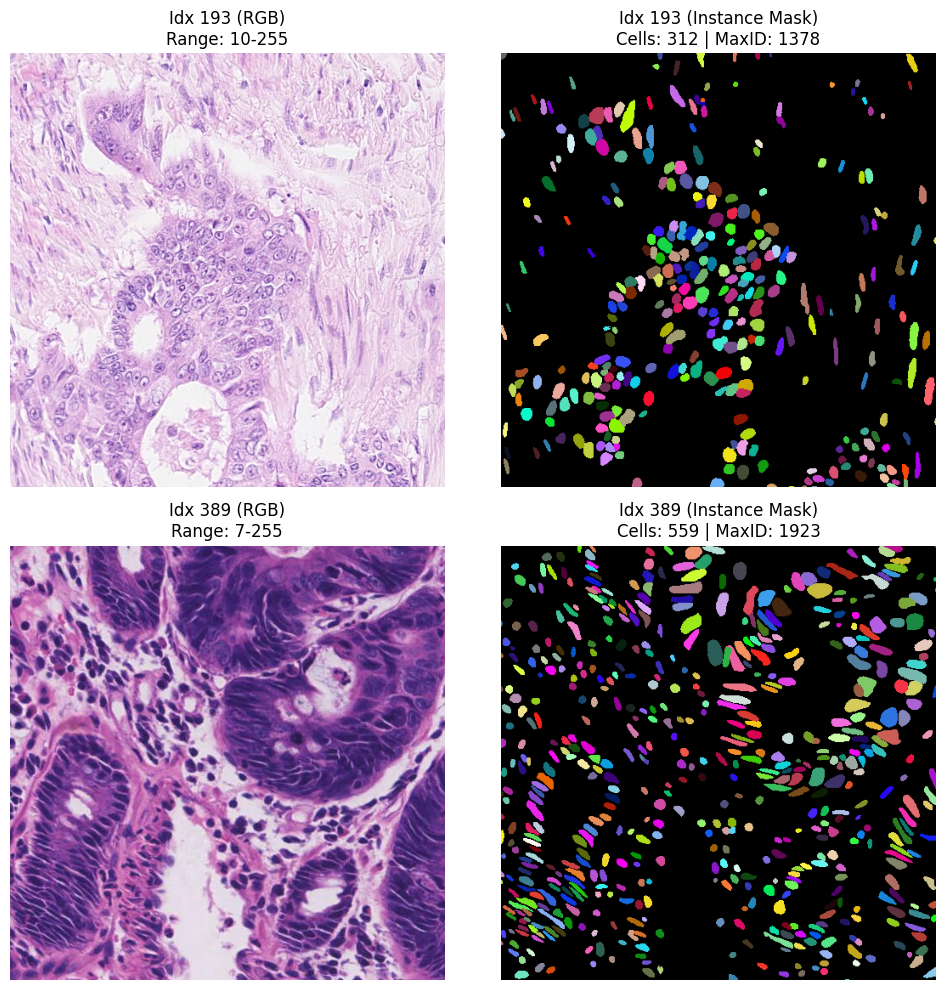

   ✨ Visualization Complete for this split.

📂 Checking Split: VAL
   ✅ Images: (60, 512, 512, 3) | uint8
   ✅ Masks:  (60, 512, 512) | int32
   👁️ Visualizing indices: [6, 42]


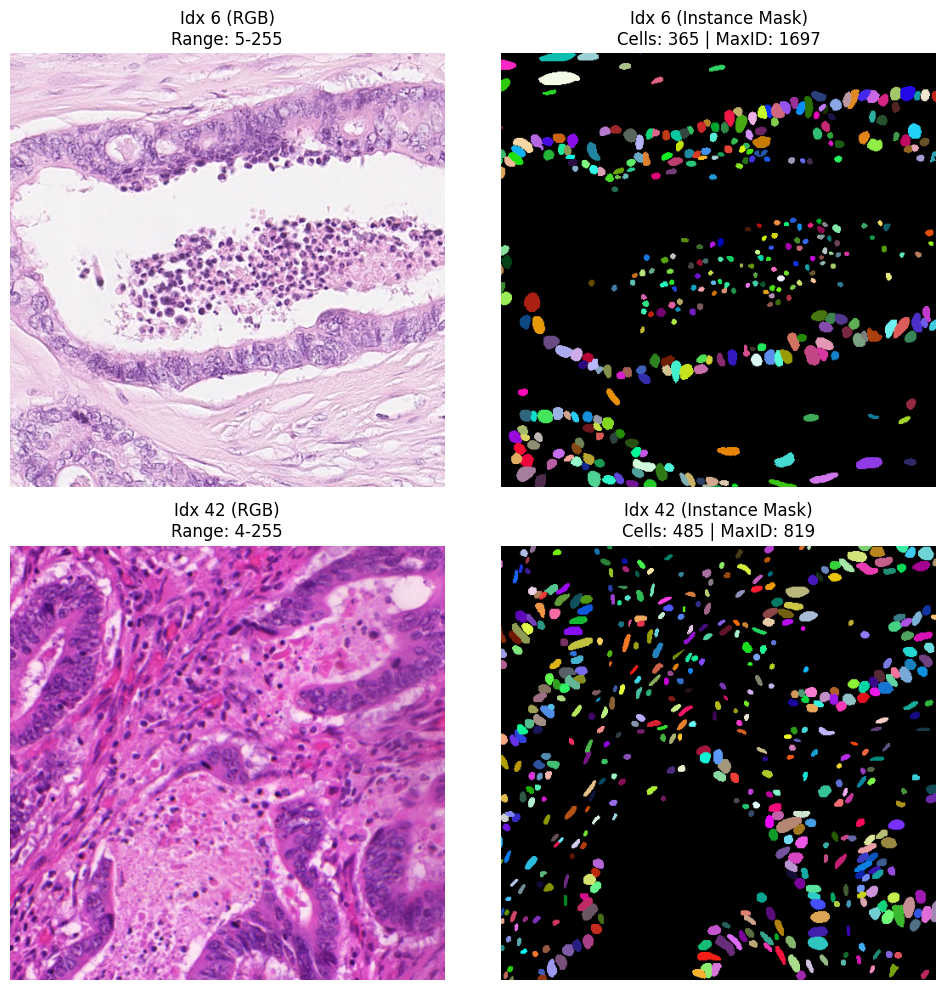

   ✨ Visualization Complete for this split.

📂 Checking Split: TEST
   ✅ Images: (151, 512, 512, 3) | uint8
   ✅ Masks:  (151, 512, 512) | int32
   👁️ Visualizing indices: [90, 110]


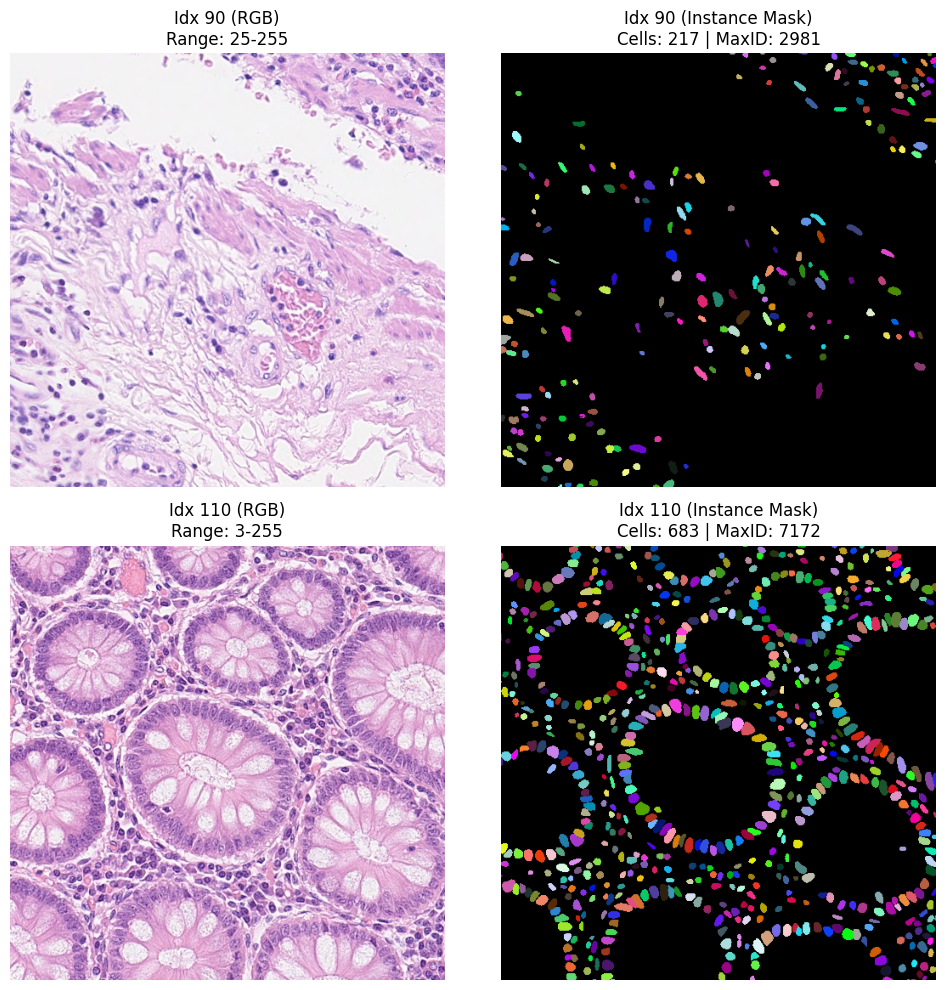

   ✨ Visualization Complete for this split.



In [26]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
# Path to your NEW merged splits
dataset_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_splits"
splits_to_check = ["train", "val", "test"]

# ---------------------------------------------------------------------
# 2. Helper: Random Color Generator
# ---------------------------------------------------------------------
def colorize_instance_map(instance_map):
    """
    Converts a 2D instance map (int) into a 3D RGB image (float) 
    where every ID gets a random bright color. Background (0) is black.
    """
    max_id = int(instance_map.max())
    if max_id == 0:
        return np.zeros((*instance_map.shape, 3))
    
    # Generate random colors (Max_ID + 1, 3)
    # We use a fixed seed per call to keep colors stable for one plot, 
    # but normally you want them random. Here just random is fine.
    colors = np.random.rand(max_id + 1, 3)
    
    # Force Background (ID 0) to Black
    colors[0] = [0, 0, 0]
    
    # Apply lookup
    return colors[instance_map]

# ---------------------------------------------------------------------
# 3. Main Verification Loop
# ---------------------------------------------------------------------
def verify_dataset():
    print(f"🚀 VERIFYING DATASET AT: {dataset_path}\n")

    for split in splits_to_check:
        split_path = os.path.join(dataset_path, split)
        
        print(f"{'='*60}")
        print(f"📂 Checking Split: {split.upper()}")
        
        if not os.path.exists(split_path):
            print(f"   ❌ Folder not found: {split_path}")
            continue

        try:
            # Open Zarrs in Read Mode
            z_img = zarr.open(os.path.join(split_path, "images.zarr"), mode='r')
            z_msk = zarr.open(os.path.join(split_path, "nuclei_masks.zarr"), mode='r')
            
            # 1. Check Shapes & Types
            n_samples = z_img.shape[0]
            print(f"   ✅ Images: {z_img.shape} | {z_img.dtype}")
            print(f"   ✅ Masks:  {z_msk.shape} | {z_msk.dtype}")
            
            if n_samples == 0:
                print("   ⚠️ Empty split.")
                continue

            # 2. Pick 2 Random Samples to Visualize
            indices = sorted(random.sample(range(n_samples), min(2, n_samples)))
            
            fig, axes = plt.subplots(len(indices), 2, figsize=(10, 5 * len(indices)))
            if len(indices) == 1: axes = np.expand_dims(axes, axis=0)
            
            print(f"   👁️ Visualizing indices: {indices}")

            for i, idx in enumerate(indices):
                # Load Data
                img = z_img[idx]      # (512, 512, 3)
                mask = z_msk[idx]     # (512, 512)
                
                # Verify Mask IDs
                unique_ids = np.unique(mask)
                num_cells = len(unique_ids) - 1 if 0 in unique_ids else len(unique_ids)
                
                # Plot Image
                ax_img = axes[i, 0]
                ax_img.imshow(img)
                ax_img.set_title(f"Idx {idx} (RGB)\nRange: {img.min()}-{img.max()}")
                ax_img.axis('off')
                
                # Plot Mask (Random Colors)
                ax_msk = axes[i, 1]
                colored_mask = colorize_instance_map(mask)
                ax_msk.imshow(colored_mask)
                ax_msk.set_title(f"Idx {idx} (Instance Mask)\nCells: {num_cells} | MaxID: {mask.max()}")
                ax_msk.axis('off')

            plt.tight_layout()
            plt.show()
            print("   ✨ Visualization Complete for this split.\n")

        except Exception as e:
            print(f"   ❌ Error reading split: {e}")

if __name__ == "__main__":
    verify_dataset()

In [2]:
import os
import shutil
from pathlib import Path

# --- CONFIGURATION ---
base_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_data")

# Mapping: Old Name -> New Name
renames = {
    "train": "lizard_train",
    "val":   "lizard_val",
    "test":  "lizard_test"
}

def rename_folders():
    print(f"📂 Checking folders in: {base_path}")
    
    if not base_path.exists():
        print("❌ Error: Base path does not exist.")
        return

    for old_name, new_name in renames.items():
        old_path = base_path / old_name
        new_path = base_path / new_name
        
        # Check if old folder exists
        if old_path.exists():
            # Check if new folder ALREADY exists (prevent overwriting)
            if new_path.exists():
                print(f"⚠️  Skipping: '{new_name}' already exists.")
            else:
                os.rename(old_path, new_path)
                print(f"✅ Renamed: '{old_name}' -> '{new_name}'")
        elif new_path.exists():
             print(f"ℹ️  '{new_name}' is already set correctly.")
        else:
            print(f"⚠️  Warning: Could not find '{old_name}' to rename.")

if __name__ == "__main__":
    rename_folders()

📂 Checking folders in: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/lizard/zarr_data
✅ Renamed: 'train' -> 'lizard_train'
✅ Renamed: 'val' -> 'lizard_val'
✅ Renamed: 'test' -> 'lizard_test'
